Import libaries

In [63]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import logging
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.callbacks import EarlyStopping


Data Loading

In [64]:
#GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [65]:
def load_data(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    return dataset['data'], dataset['labels']

data_path = 'EMNIST_Byclass_Small/'
X_train, y_train = load_data(data_path+'emnist_train.pkl')
X_test, y_test = load_data(data_path+'emnist_test.pkl')
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train data type:", X_train.dtype)
print("y_train data type:", y_train.dtype)

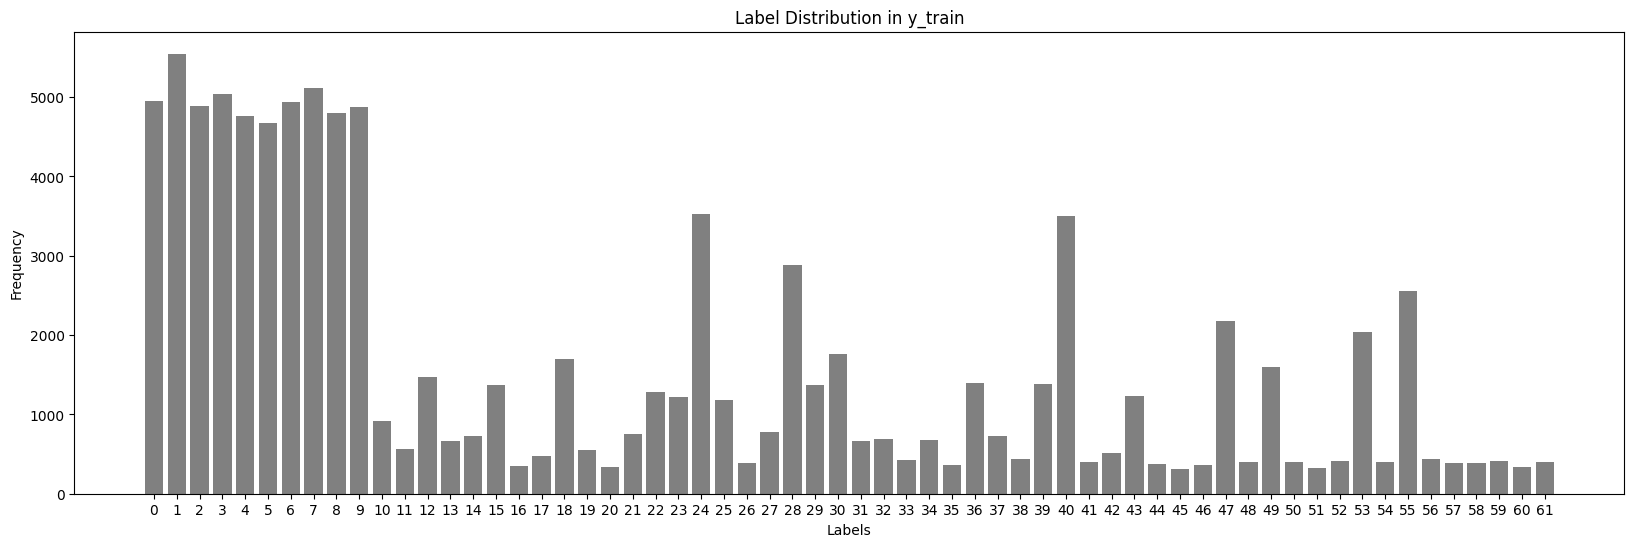

In [67]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 6))
plt.bar(unique, counts, color='gray')
plt.title('Label Distribution in y_train')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(unique)
plt.show()

Outliers

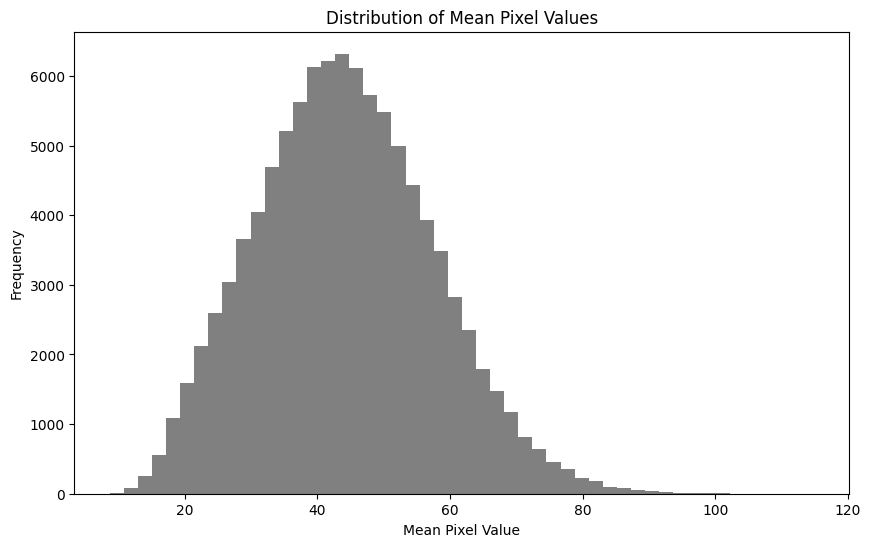

In [68]:
mean_pixel_values = np.mean(X_train, axis=(1, 2))
plt.figure(figsize=(10, 6))
plt.hist(mean_pixel_values, bins=50, color='gray')
plt.title('Distribution of Mean Pixel Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.show()

Intensity

In [69]:
print("Min pixel value:", np.min(X_train))
print("Max pixel value:", np.max(X_train))
print("Mean pixel value:", np.mean(X_train))
print("Std pixel value:", np.std(X_train))

Min pixel value: 0
Max pixel value: 255
Mean pixel value: 44.199759910714285
Std pixel value: 84.52433433555304


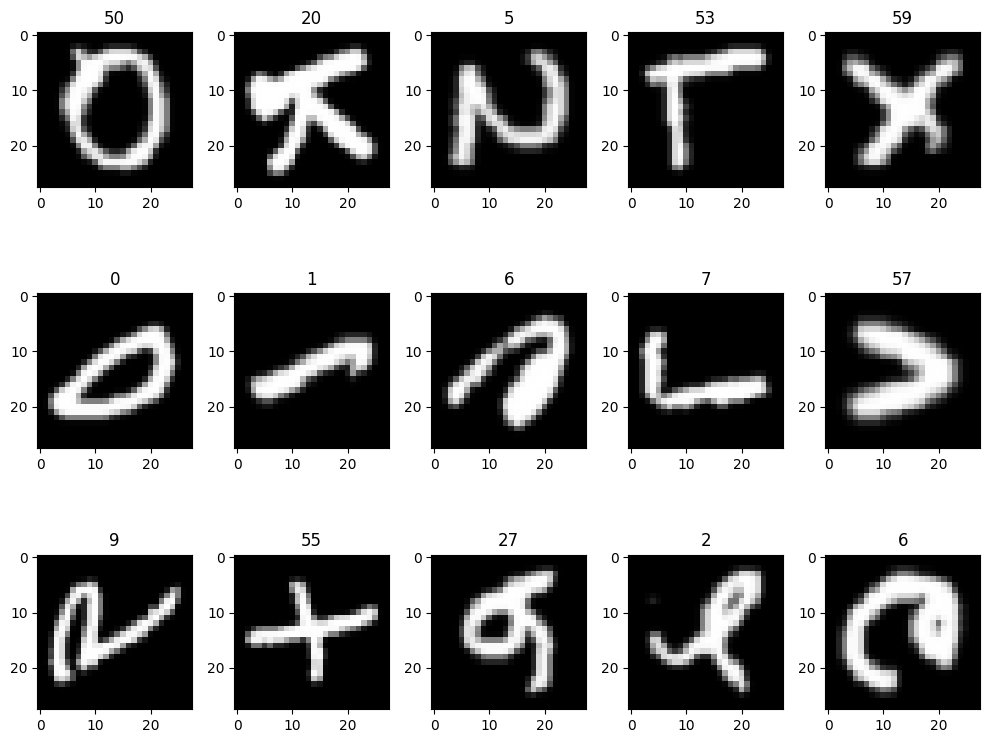

In [70]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28, 28]), cmap='gray')
    ax.set_title(y_train[i])
plt.tight_layout()
plt.show()

In [71]:
#data normalised to 0 - 1
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

num_classes = 62
#Change the labels to one hot for classification
train_labels = to_categorical(y_train, num_classes)
test_labels = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}, Training labels shape: {train_labels.shape}")
print(f"Test data shape: {y_test.shape}, Test labels shape: {test_labels.shape}")

Training data shape: (100000, 28, 28, 1), Training labels shape: (100000, 62)
Test data shape: (20000,), Test labels shape: (20000, 62)


In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
#No augmentation data generator
train_datagenn_no_aug = ImageDataGenerator()
# No augmentation for the validation data, just rescaling
val_datagen = ImageDataGenerator()

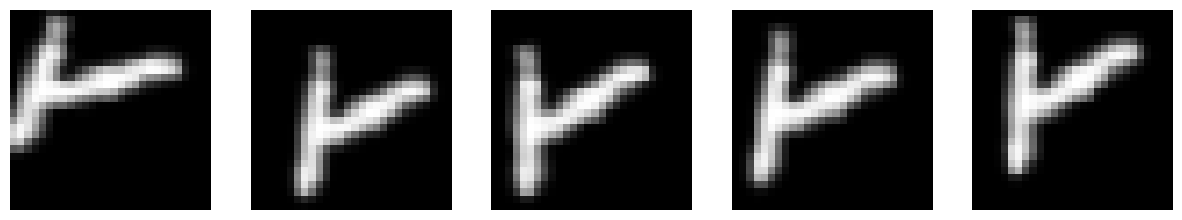

In [73]:
sample_image = X_train[0].reshape((1, 28, 28, 1))
augmented_images = train_datagen.flow(sample_image, batch_size=1)

# Plot several augmented versions of the same image
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Generate augmented image
    aug_image = augmented_images.__next__()[0].reshape(28, 28)

    # Display the augmented image
    axes[i].imshow(aug_image, cmap='gray')
    axes[i].axis('off')

plt.show()

In [74]:
#Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [75]:
#set up base parameters
epochs = 30
batch_size = 32
loss="sparse_categorical_crossentropy"
#loss="categorical_crossentropy"
input_shape = (28, 28, 1)
num_classes = 62
hyperparameters = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    #Have activation and output activation functions in hyperparameter incase they should be tuned
    'activation' : 'relu',
    'output_activation' : 'softmax'
}

In [76]:
#Flow the generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_no_aug = train_datagenn_no_aug.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

Residual Network Builder

In [77]:

def se_block(inputs, reduction_ratio=16):
    #Self attention
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape([1, 1, filters])(se)
    return layers.Multiply()([inputs, se])

def residual_block(inputs, filters, kernel_size=4, stride=1, dropout_rate=0.3, activation='relu', use_se=True):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add attention (Squeeze-and-Excitation block) if specified
    if use_se:
        x = se_block(x)

    # Adjust inputs if necessary (to match dimensions)
    if stride != 1 or inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        inputs = layers.BatchNormalization()(inputs)

    # Dropout before residual addition
    x = layers.Dropout(dropout_rate)(x)

    # Residual connection
    x = layers.Add()([x, inputs])
    x = layers.Activation(activation)(x)

    return x

def build_resnet(input_shape, num_classes, hyperparameters):
    inputs = layers.Input(shape=input_shape)
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = hyperparameters['hidden_size']
    activation= hyperparameters['activation']
    regularization_rate = hyperparameters['regularization_rate']
    # Initial convolution layer
    x = layers.Conv2D(hidden_size, (4, 4), padding='same', strides=1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Residual blocks
    x = residual_block(x, hidden_size, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*2, stride=2, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*4, stride=2, dropout_rate=dropout_rate, activation=activation)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hidden_size*8, activation=activation,
                    kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(regularization_rate))(x)

    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [78]:
def build_vggnet(input_shape, num_classes, hp, num_conv_blocks=5):
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = int(hyperparameters['hidden_size'] / 2)  # Used for Dense layers
    activation = hyperparameters['activation']

    inputs = layers.Input(shape=input_shape)

    # VGG blocks
    x = inputs
    current_height, current_width = input_shape[:2]  # Get spatial dimensions

    for block in range(num_conv_blocks):
        # Add 2 or 3 Conv layers depending on the block
        num_conv_layers = 2 if block < 3 else 3
        for _ in range(num_conv_layers):
            x = layers.Conv2D(int(hidden_size), (4, 4), padding='same')(x)  # Convert hidden_size to int
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation)(x)

        # Check spatial dimensions before applying MaxPooling
        if current_height > 1 and current_width > 1:
            x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
            current_height //= 2
            current_width //= 2
        else:
            break  # Avoid further downscaling if spatial dimensions are too small

        # Double filter size after each block
        hidden_size *= 2

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(hyperparameters['regularization_rate']))(x)
    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  # 'loss' added to hyperparameters

    return model

In [79]:
def build_mlp(input_shape, num_classes, hidden_size):
    hidden_size = hyperparameters['hidden_size']
    dropout_rate = hyperparameters['dropout_rate']
    activation= hyperparameters['activation']
    inputs = layers.Input(shape=input_shape)

    # Flatten the input (28, 28, 1) -> (784,)
    x = layers.Flatten(input_shape=input_shape)(inputs)

    x = layers.Dense(hidden_size*8)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(hidden_size*4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(hidden_size*2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate+0.1)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(hyperparameters['regularization_rate']))(x)

    model = models.Model(inputs, outputs)

    optimizer=Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [80]:
model_resnet = build_resnet(input_shape, num_classes, hyperparameters)
model_resnet.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_168 (Conv2D)       │ (None, 28, 28, 64)     │          1,088 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 28, 28, 64)     │            256 │ conv2d_168[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_173            │ (None, 28, 28, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_169 (Conv2D)       │ (None, 28, 28, 64)     │         65,600 │ activation_173[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 28, 28, 64)     │            256 │ conv2d_169[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_174            │ (None, 28, 28, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_93 (Dropout)      │ (None, 28, 28, 64)     │              0 │ activation_174[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_170 (Conv2D)       │ (None, 28, 28, 64)     │         65,600 │ dropout_93[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 28, 28, 64)     │            256 │ conv2d_170[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_116 (Dense)         │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_117 (Dense)         │ (None, 64)             │            320 │ dense_116[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, 1, 1, 64)       │              0 │ dense_117[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_24 (Multiply)    │ (None, 28, 28, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ reshape_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_94 (Dropout) 

 Total params: 2,320,474 (8.85 MB)

 Trainable params: 2,317,786 (8.84 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [81]:
model_vggnet = build_vggnet(input_shape, num_classes, hyperparameters)
model_vggnet.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_177 (Conv2D)                  │ (None, 28, 28, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_198              │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_180 (Activation)          │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_178 (Conv2D)                  │ (None, 28, 28, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_199              │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_181 (Activation)          │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_179 (Conv2D)                  │ (None, 14, 14, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_200              │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_182 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_180 (Conv2D)                  │ (None, 14, 14, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_201              │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_183 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_181 (Conv2D)                  │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_202              │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_184 (Activation)          │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_182 (Conv2D)                  │ (None, 7, 7, 128)           │         262,2

 Total params: 19,003,390 (72.49 MB)

 Trainable params: 18,997,886 (72.47 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [82]:
model_mlp = build_mlp(input_shape, num_classes, hyperparameters)
model_mlp.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_210              │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_192 (Activation)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_211              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_193 (Activation)          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_212              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_194 (Activation)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 62)                  │           7,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 577,726 (2.20 MB)

 Trainable params: 575,934 (2.20 MB)

 Non-trainable params: 1,792 (7.00 KB)

Hyperparameter tuning

In [83]:
def plot_model_accuracies(model_groups):
    for group_name, models in model_groups.items():
        plt.figure(figsize=(8, 6))

        # Loop over each model in the group
        for i, (model_name, (model, history)) in enumerate(models.items()):

            # Access the history attribute to get training metrics
            history_data = history.history

            # Plot training and validation accuracy
            plt.plot(history_data['accuracy'], label=f'{model_name} training Accuracy')
            plt.plot(history_data['val_accuracy'], label=f'{model_name} validation Accuracy')

        # Display the plot

        plt.title(f"Performance of Models in {group_name}")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


In [84]:
def single_hyperparameter_tuner(parameter, values):
    epochs = 20
    hyperparameters = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    'activation' : 'relu',
    'output_activation' : 'softmax'
    }
    # Initiate results to be return in a dictionary of dictionary (groups of models)
    res = {
        'resnet' : {},
        'vggnet' : {},
        'mlp' : {}
    }

    for val in values:
        hyperparameters[parameter] = val
        model = build_resnet(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['resnet']['resnet_'+parameter+'_'+str(val)] = (model, history)

        model = build_vggnet(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['vggnet']['vggnet_'+parameter+'_'+str(val)] = (model, history)

        model = build_mlp(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['mlp']['mlp_'+parameter+'_'+str(val)] = (model, history)

    return res

In [ ]:
hidden_test = single_hyperparameter_tuner('hidden_size', [16, 32, 64])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.4540 - loss: 2.0727 - val_accuracy: 0.7752 - val_loss: 0.6577
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7517 - loss: 0.7656 - val_accuracy: 0.8174 - val_loss: 0.5236
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7850 - loss: 0.6411 - val_accuracy: 0.8275 - val_loss: 0.4912
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8006 - loss: 0.5900 - val_accuracy: 0.8375 - val_loss: 0.4598
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8087 - loss: 0.5571 - val_accuracy: 0.8371 - val_loss: 0.4647
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.8161 - loss: 0.5336 - val_accuracy: 0.8413 - val_loss: 0.4502
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8175 - loss: 0.5222 - val_accuracy: 0.8370 - val_loss: 0.4579
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8215 -

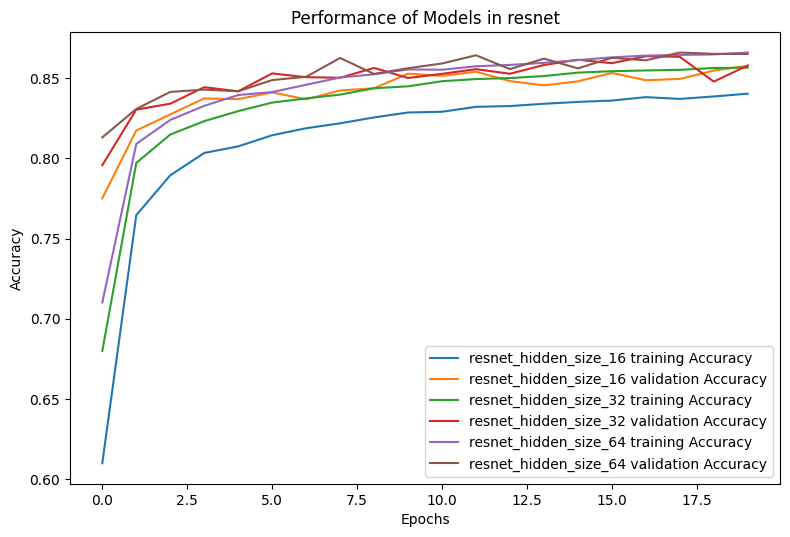

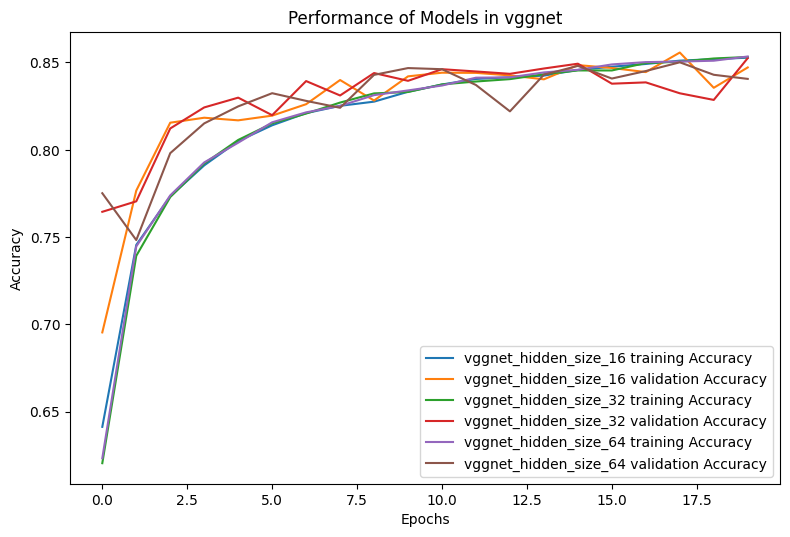

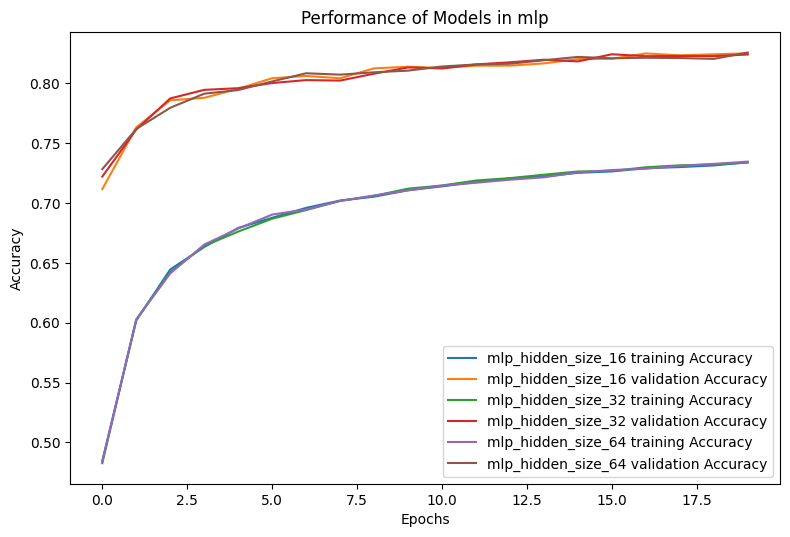

In [ ]:
plot_model_accuracies(hidden_test)


In [ ]:
dropout_test = single_hyperparameter_tuner('dropout_rate', [0.1, 0.2, 0.3, 0.4])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.6398 - loss: 1.2788 - val_accuracy: 0.7925 - val_loss: 0.6782
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8175 - loss: 0.5119 - val_accuracy: 0.7972 - val_loss: 0.5729
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8339 - loss: 0.4534 - val_accuracy: 0.8390 - val_loss: 0.4557
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8445 - loss: 0.4286 - val_accuracy: 0.8532 - val_loss: 0.4124
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8485 - loss: 0.4133 - val_accuracy: 0.8466 - val_loss: 0.4205
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8556 - loss: 0.3918 - val_accuracy: 0.8450 - val_loss: 0.4302
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8556 - loss: 0.3821 - val_accuracy: 0.8532 - val_loss: 0.4026
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8576 -

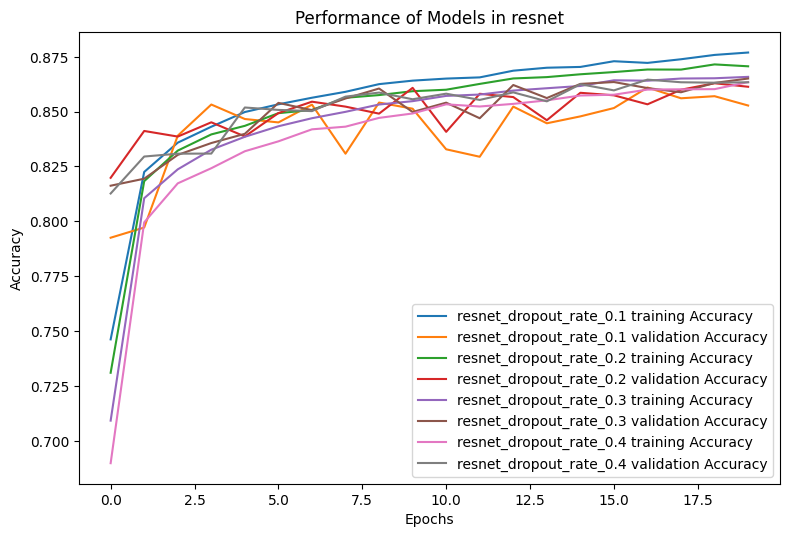

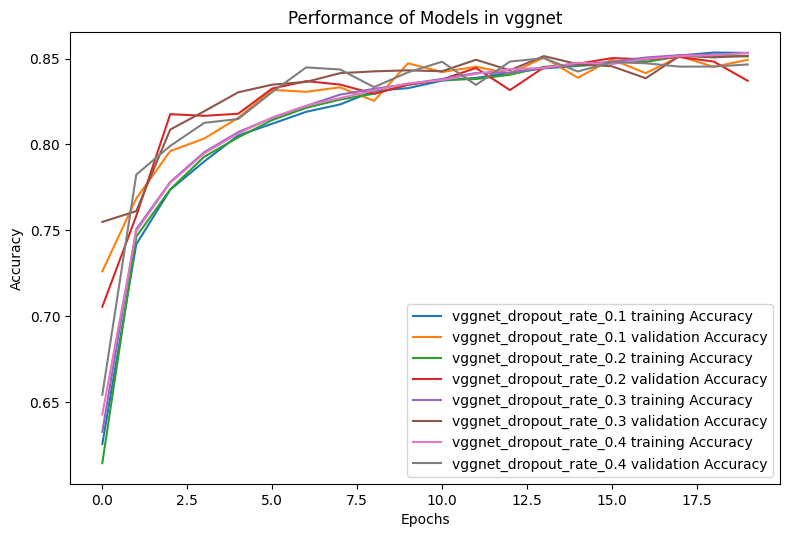

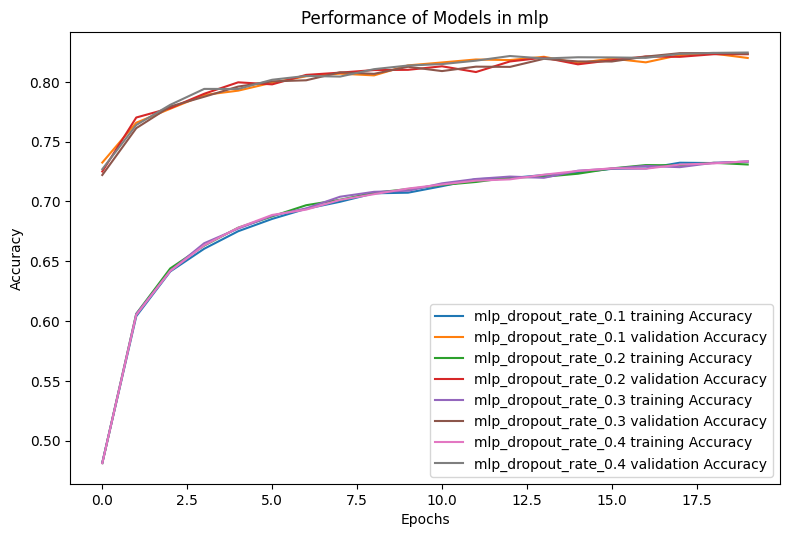

In [ ]:
plot_model_accuracies(dropout_test)

In [ ]:
lr_test = single_hyperparameter_tuner('learning_rate', [1e-2, 1e-3, 1e-4])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - accuracy: 0.4411 - loss: 2.0670 - val_accuracy: 0.7463 - val_loss: 0.7698
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.7398 - loss: 0.8008 - val_accuracy: 0.8074 - val_loss: 0.5468
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.7774 - loss: 0.6710 - val_accuracy: 0.8207 - val_loss: 0.4995
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.7920 - loss: 0.6139 - val_accuracy: 0.8174 - val_loss: 0.5031
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8005 - loss: 0.5891 - val_accuracy: 0.8259 - val_loss: 0.4870
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8113 - loss: 0.5615 - val_accuracy: 0.8414 - val_loss: 0.4473
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8155 - loss: 0.5419 - val_accuracy: 0.8403 - val_loss: 0.4451
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8204 -

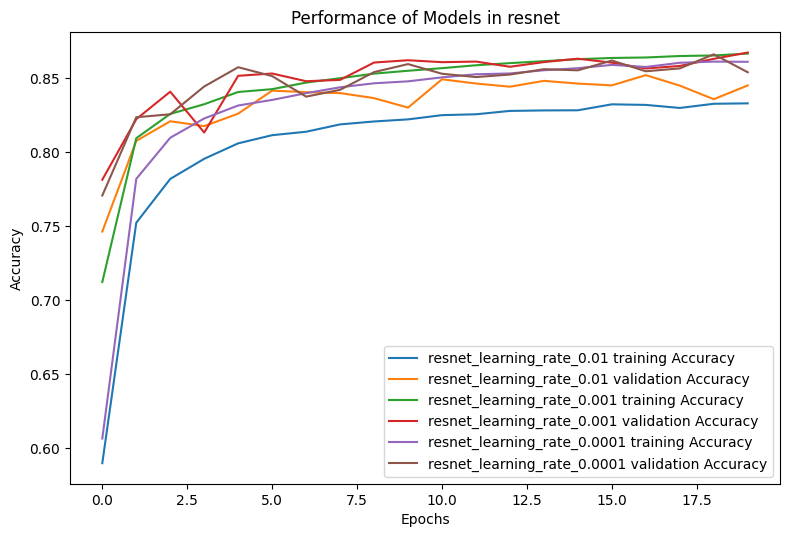

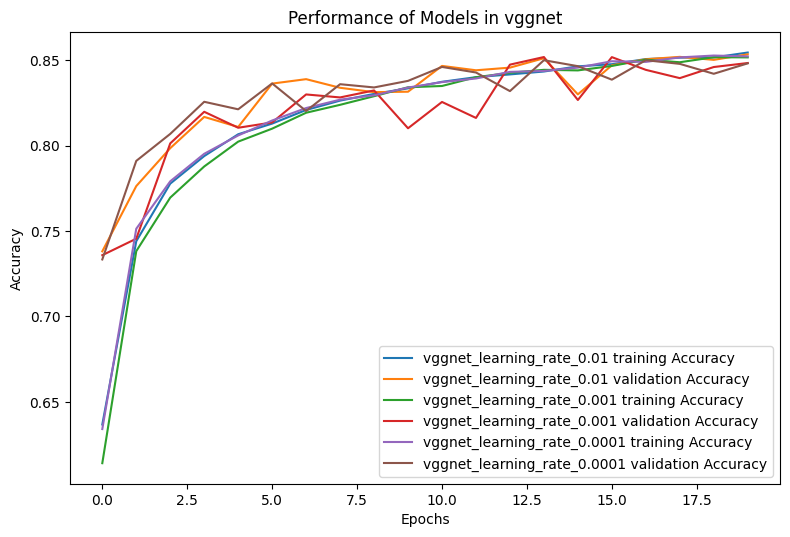

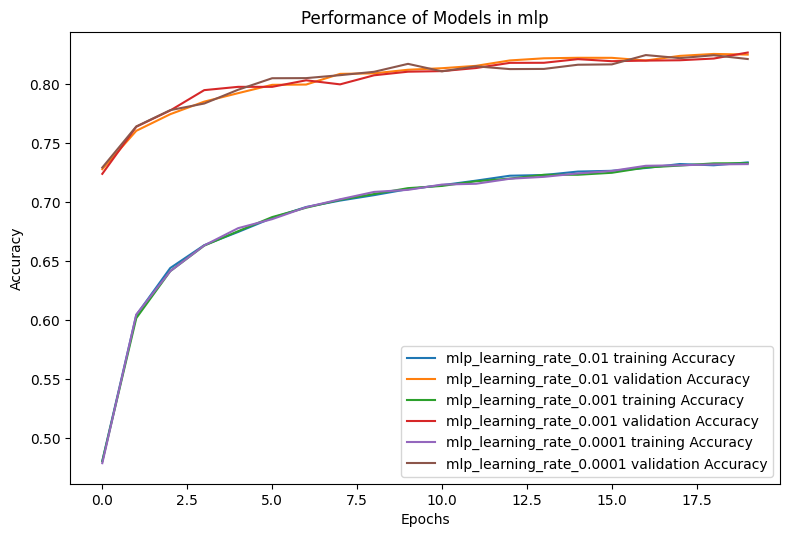

In [ ]:
plot_model_accuracies(lr_test)

In [49]:
regularization_test = single_hyperparameter_tuner('regularization_rate', [0.0, 0.01, 0.03])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - accuracy: 0.5870 - loss: 1.5099 - val_accuracy: 0.8108 - val_loss: 0.5600
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8040 - loss: 0.5617 - val_accuracy: 0.8329 - val_loss: 0.4656
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8210 - loss: 0.5025 - val_accuracy: 0.8356 - val_loss: 0.4737
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8314 - loss: 0.4695 - val_accuracy: 0.8468 - val_loss: 0.4314
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8390 - loss: 0.4428 - val_accuracy: 0.8442 - val_loss: 0.4223
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8449 - loss: 0.4281 - val_accuracy: 0.8533 - val_loss: 0.4137
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8480 - loss: 0.4126 - val_accuracy: 0.8542 - val_loss: 0.3956
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8515 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.3860 - loss: 2.4487 - val_accuracy: 0.7282 - val_loss: 0.8512
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.5903 - loss: 1.4123 - val_accuracy: 0.7659 - val_loss: 0.7089
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6373 - loss: 1.2221 - val_accuracy: 0.7788 - val_loss: 0.6414
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6614 - loss: 1.1128 - val_accuracy: 0.7963 - val_loss: 0.5978
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6770 - loss: 1.0546 - val_accuracy: 0.7956 - val_loss: 0.5895
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6874 - loss: 1.0122 - val_accuracy: 0.8030 - val_loss: 0.5620
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.6937 - loss: 0.9855 - val_accuracy: 0.8058 - val_loss: 0.5523
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.7004 - loss: 0.95

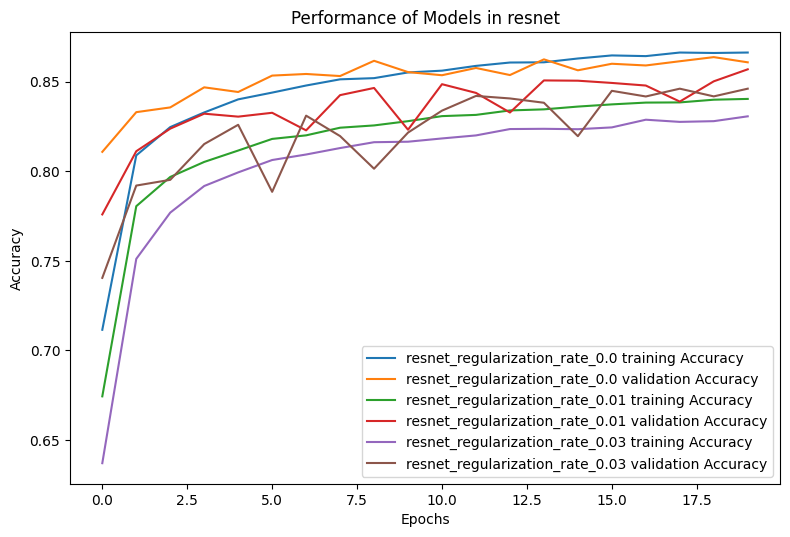

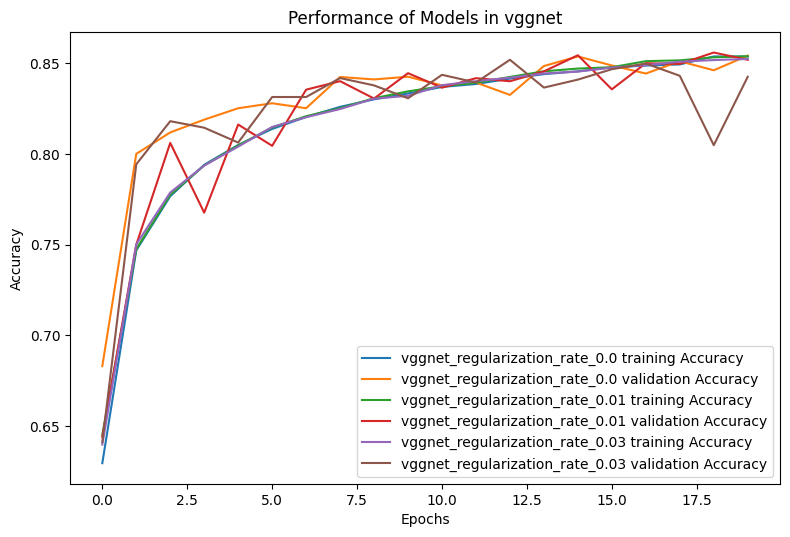

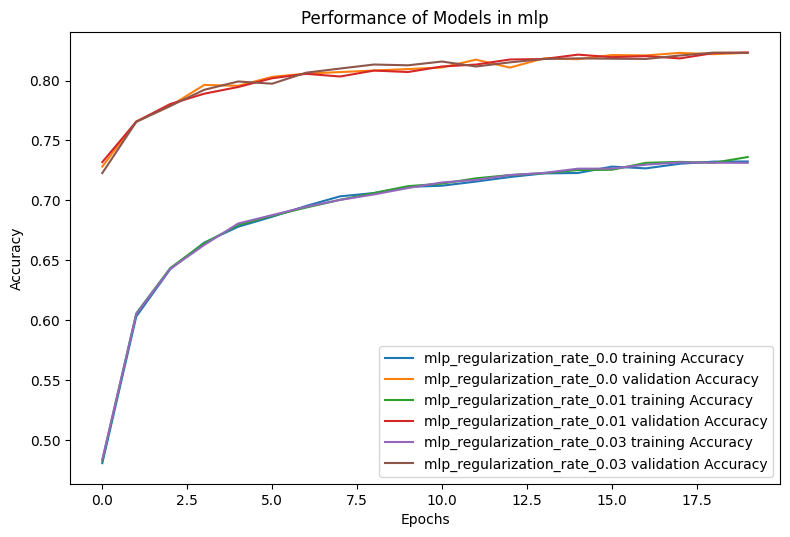

In [50]:
plot_model_accuracies(regularization_test)

In [ ]:
# Batch tests requires data to be flowed again and cant use the tuner function
batch_test = {
    'resnet' : {},
    'vggnet' : {},
    'mlp' : {}
}
for bs in [16, 32, 64, 128]:
    train_generator = train_datagen.flow(X_train, y_train, batch_size=bs)

    # Create nested dictionaries if they don't exist
    model = build_resnet(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['resnet']['resnet_batch_'+str(bs)] = (model, history)

    model = build_vggnet(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['vggnet']['vggnet_batch_'+str(bs)] = (model, history)

    model = build_mlp(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['mlp']['mlp_batch_'+str(bs)] = (model, history)

Epoch 1/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - accuracy: 0.5805 - loss: 1.5057 - val_accuracy: 0.8126 - val_loss: 0.5458
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.7974 - loss: 0.5885 - val_accuracy: 0.8299 - val_loss: 0.4868
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8169 - loss: 0.5167 - val_accuracy: 0.8332 - val_loss: 0.4982
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8315 - loss: 0.4731 - val_accuracy: 0.8510 - val_loss: 0.4180
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8365 - loss: 0.4517 - val_accuracy: 0.8498 - val_loss: 0.4315
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8427 - loss: 0.4342 - val_accuracy: 0.8442 - val_loss: 0.4234
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8460 - loss: 0.4165 - val_accuracy: 0.8489 - val_loss: 0.4169
Epoch 8/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.8481 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.3718 - loss: 2.4629 - val_accuracy: 0.7165 - val_loss: 0.8832
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.5615 - loss: 1.5332 - val_accuracy: 0.7599 - val_loss: 0.7321
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.5993 - loss: 1.3707 - val_accuracy: 0.7766 - val_loss: 0.6708
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.6233 - loss: 1.2717 - val_accuracy: 0.7825 - val_loss: 0.6328
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.6412 - loss: 1.2016 - val_accuracy: 0.7869 - val_loss: 0.6140
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.6492 - loss: 1.1690 - val_accuracy: 0.7965 - val_loss: 0.5897
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.6595 - loss: 1.1294 - val_accuracy: 0.7924 - val_loss: 0.5783
Epoch 8/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.6619 - loss: 1.1195 - val

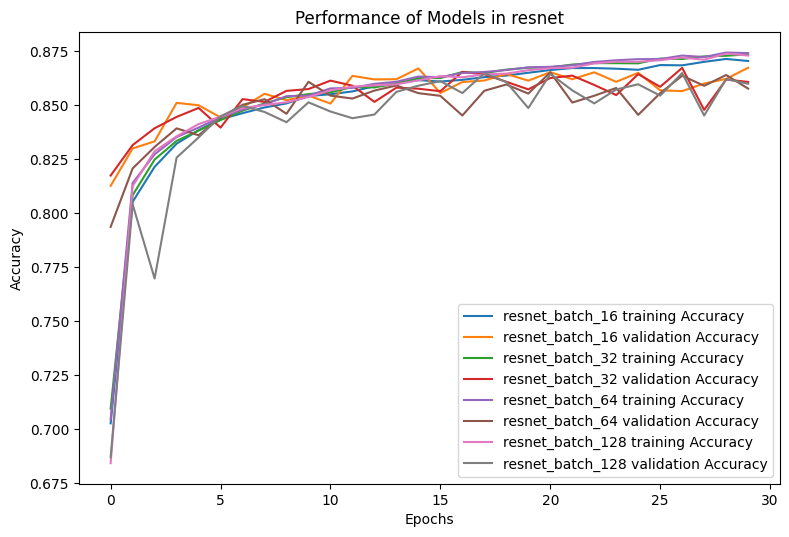

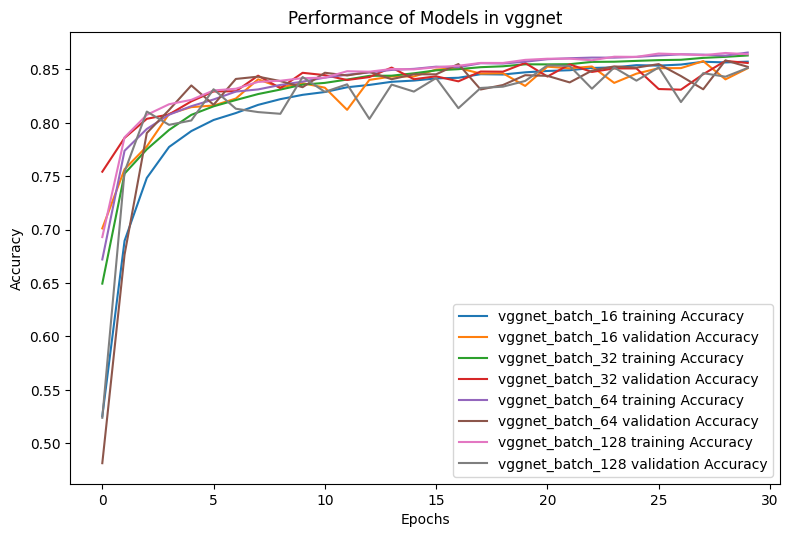

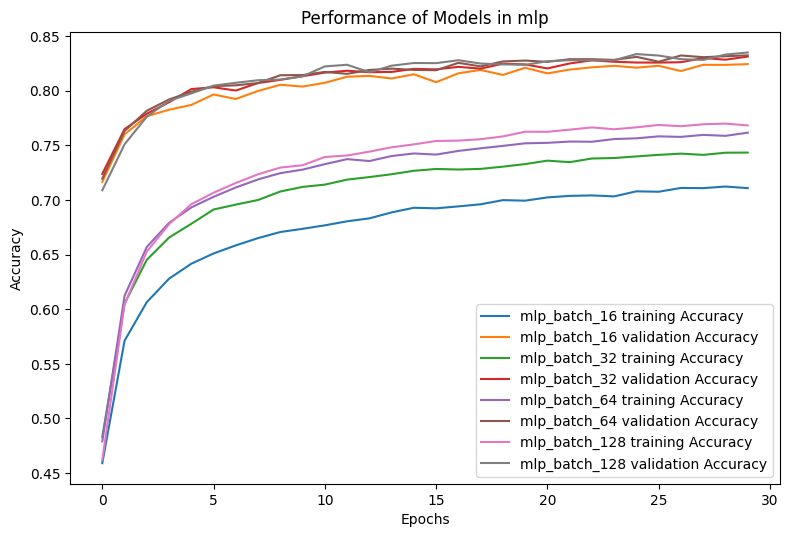

In [ ]:
plot_model_accuracies(batch_test)

In [44]:
# augmentation tests requires differnt data generators and cant use the tuner function natively
augmentation_test = {
    'resnet' : {},
    'vggnet' : {},
    'mlp' : {}
}
for data_gen, name in [(train_generator, 'aug'), (train_generator_no_aug, 'no_aug')]:

    model = build_resnet(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['resnet']['resnet_'+name] = (model, history)

    model = build_vggnet(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['vggnet']['vggnet_'+name] = (model, history)

    model = build_mlp(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['mlp']['mlp_'+name] = (model, history)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.5890 - loss: 1.4909 - val_accuracy: 0.7997 - val_loss: 0.5786
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8039 - loss: 0.5625 - val_accuracy: 0.8216 - val_loss: 0.5168
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.8189 - loss: 0.5108 - val_accuracy: 0.8392 - val_loss: 0.4407
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8308 - loss: 0.4731 - val_accuracy: 0.8354 - val_loss: 0.4753
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8373 - loss: 0.4486 - val_accuracy: 0.8396 - val_loss: 0.4569
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8429 - loss: 0.4287 - val_accuracy: 0.8447 - val_loss: 0.4217
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8459 - loss: 0.4198 - val_accuracy: 0.8536 - val_loss: 0.4105
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.8509 - loss: 0.40

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.3849 - loss: 2.4398 - val_accuracy: 0.7175 - val_loss: 0.8779
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5914 - loss: 1.4045 - val_accuracy: 0.7610 - val_loss: 0.7128
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6383 - loss: 1.2117 - val_accuracy: 0.7768 - val_loss: 0.6463
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6611 - loss: 1.1086 - val_accuracy: 0.7889 - val_loss: 0.6103
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6777 - loss: 1.0512 - val_accuracy: 0.7952 - val_loss: 0.5816
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6854 - loss: 1.0078 - val_accuracy: 0.7980 - val_loss: 0.5595
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6936 - loss: 0.9850 - val_accuracy: 0.8033 - val_loss: 0.5500
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7030 - loss: 0.96

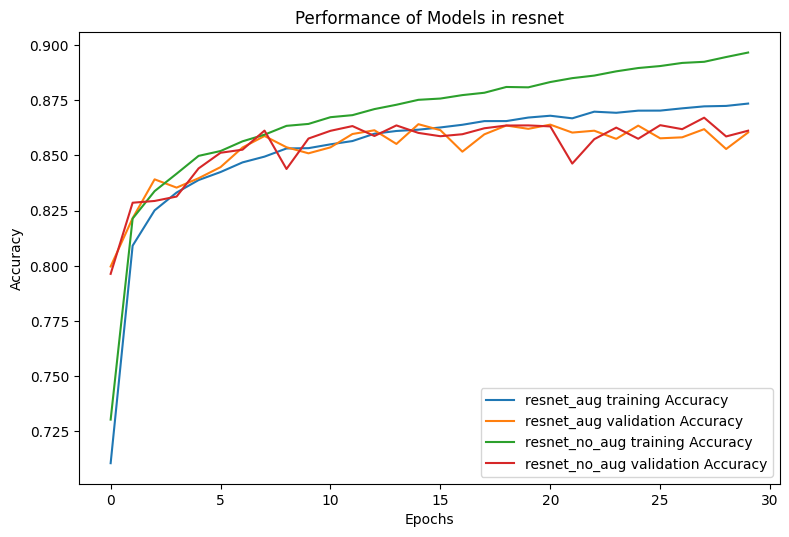

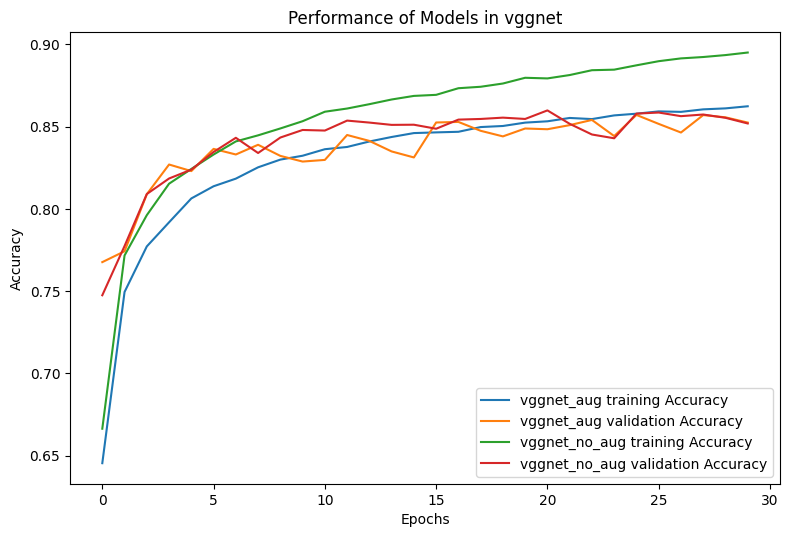

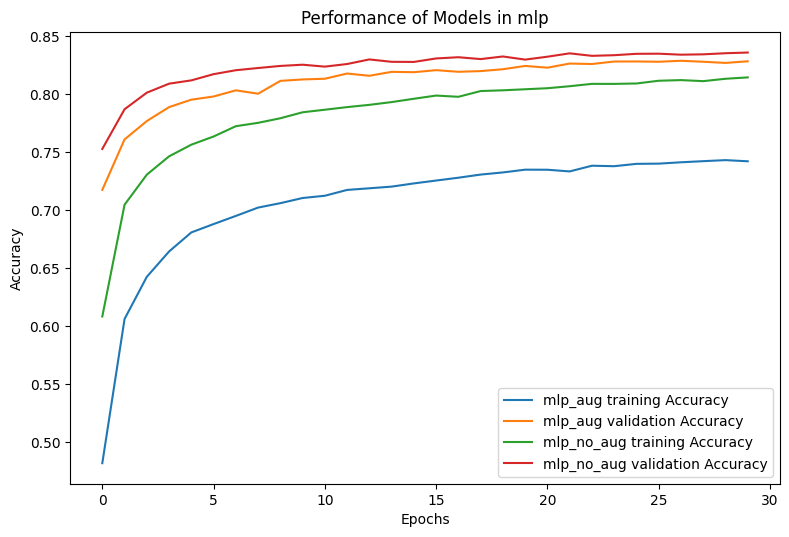

In [45]:
plot_model_accuracies(augmentation_test)

In [47]:
import pandas as pd
def summarize_model_accuracies(model_groups):
    # Create dictionaries to store accuracy statistics
    training_accuracies = {}
    validation_accuracies = {}

    # Loop over each group of models
    for group_name, models in model_groups.items():
        train_acc_list = []
        val_acc_list = []

        for model_name, (model, history) in models.items():
            history_data = history.history
            # Calculate statistics
            avg_train_acc = sum(history_data['accuracy']) / len(history_data['accuracy'])
            max_train_acc = max(history_data['accuracy'])

            avg_val_acc = sum(history_data['val_accuracy']) / len(history_data['val_accuracy'])
            max_val_acc = max(history_data['val_accuracy'])

            # Store results in dictionaries
            training_accuracies[model_name] = {'Average': avg_train_acc, 'Maximum': max_train_acc}
            validation_accuracies[model_name] = {'Average': avg_val_acc, 'Maximum': max_val_acc}

    # Convert dictionaries to DataFrames
    train_df = pd.DataFrame(training_accuracies).T
    val_df = pd.DataFrame(validation_accuracies).T

    # Create combined dataframe for easier comparison
    combined_df = pd.DataFrame({
        'Training Average': train_df['Average'],
        'Training Maximum': train_df['Maximum'],
        'Validation Average': val_df['Average'],
        'Validation Maximum': val_df['Maximum']
    })
    return combined_df


Tables for evaluation of all the accuracies

In [ ]:
summarize_model_accuracies(hidden_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_hidden_size_16,0.811943,0.840463,0.841228,0.85780
resnet_hidden_size_32,0.833848,0.856713,0.849117,0.86380
resnet_hidden_size_64,0.843876,0.866150,0.853070,0.86615
vggnet_hidden_size_16,0.816854,0.852750,0.826393,0.85570
vggnet_hidden_size_32,0.815760,0.853150,0.829755,0.85250
vggnet_hidden_size_64,0.816491,0.853425,0.827568,0.85010
mlp_hidden_size_16,0.691064,0.733763,0.803775,0.82470
mlp_hidden_size_32,0.691159,0.733537,0.804067,0.82390
mlp_hidden_size_64,0.691197,0.734350,0.804132,0.82535


In [ ]:
summarize_model_accuracies(dropout_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_dropout_rate_0.1,0.855186,0.876900,0.842405,0.86095
resnet_dropout_rate_0.2,0.850314,0.871487,0.850205,0.86290
resnet_dropout_rate_0.3,0.844181,0.865812,0.850255,0.86505
resnet_dropout_rate_0.4,0.837663,0.863425,0.851550,0.86455
vggnet_dropout_rate_0.1,0.815891,0.853562,0.826680,0.85130
vggnet_dropout_rate_0.2,0.815786,0.851525,0.826358,0.85095
vggnet_dropout_rate_0.3,0.818413,0.853275,0.832247,0.85170
vggnet_dropout_rate_0.4,0.818594,0.853363,0.825725,0.85030
mlp_dropout_rate_0.1,0.690194,0.733262,0.803798,0.82345
mlp_dropout_rate_0.2,0.690965,0.732200,0.803542,0.82295


In [ ]:
summarize_model_accuracies(lr_test )

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_learning_rate_0.01,0.805199,0.832762,0.833015,0.85180
resnet_learning_rate_0.001,0.844403,0.866350,0.849330,0.86705
resnet_learning_rate_0.0001,0.831468,0.860925,0.846122,0.86585
vggnet_learning_rate_0.01,0.817330,0.854437,0.829110,0.85340
vggnet_learning_rate_0.001,0.814106,0.851687,0.821188,0.85180
vggnet_learning_rate_0.0001,0.817779,0.852675,0.829280,0.84995
mlp_learning_rate_0.01,0.691234,0.733712,0.804083,0.82570
mlp_learning_rate_0.001,0.690718,0.733050,0.803450,0.82690
mlp_learning_rate_0.0001,0.690891,0.732275,0.803737,0.82475


In [51]:
summarize_model_accuracies(regularization_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_regularization_rate_0.0,0.844660,0.866162,0.851758,0.86360
resnet_regularization_rate_0.01,0.817203,0.840288,0.835443,0.85680
resnet_regularization_rate_0.03,0.803226,0.830575,0.821218,0.84600
vggnet_regularization_rate_0.0,0.816807,0.853825,0.828793,0.85430
vggnet_regularization_rate_0.01,0.818227,0.853950,0.820068,0.85600
vggnet_regularization_rate_0.03,0.817548,0.852450,0.822390,0.85200
mlp_regularization_rate_0.0,0.690763,0.732487,0.804220,0.82315
mlp_regularization_rate_0.01,0.691702,0.736200,0.803727,0.82335
mlp_regularization_rate_0.03,0.691366,0.731725,0.804053,0.82330


In [ ]:
summarize_model_accuracies(batch_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_batch_16,0.850978,0.871275,0.855290,0.86720
resnet_batch_32,0.852975,0.873425,0.854295,0.86715
resnet_batch_64,0.853616,0.874250,0.849838,0.86510
resnet_batch_128,0.852311,0.873775,0.842380,0.86475
vggnet_batch_16,0.818050,0.857288,0.830023,0.85780
vggnet_batch_32,0.832182,0.863087,0.835953,0.85800
vggnet_batch_64,0.838378,0.865838,0.822740,0.85850
vggnet_batch_128,0.841590,0.865412,0.817752,0.85385
mlp_batch_16,0.673378,0.712250,0.805678,0.82430
mlp_batch_32,0.707763,0.743325,0.811907,0.83120


In [48]:
summarize_model_accuracies(augmentation_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_aug,0.852827,0.873500,0.852907,0.86415
resnet_no_aug,0.867293,0.896637,0.853682,0.86710
vggnet_aug,0.830666,0.862363,0.837188,0.85710
vggnet_no_aug,0.855501,0.895037,0.841327,0.85985
mlp_aug,0.707150,0.743137,0.810925,0.82880
mlp_no_aug,0.782840,0.814462,0.823543,0.83590


In [85]:
# Summary the best hyperparameters for each model
best_hyperparams_resnet = {
    'hidden_size': 64,
    'dropout_rate': 0.4,
    'learning_rate': 0.001,
    'regularization_rate': 0.0,
    'activation': 'relu',
    'output_activation': 'softmax'
}

best_hyperparams_vggnet = {
    'hidden_size': 32,
    'dropout_rate': 0.2,
    'learning_rate': 0.01,
    'regularization_rate': 0.01,
    'activation': 'relu',
    'output_activation': 'softmax'
}

best_hyperparams_mlp = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    'activation' : 'relu',
    'output_activation' : 'softmax'
}

best_batch_size_resnet = 16
best_batch_size_vggnet = 32
best_batch_size_mlp = 128

Evaluation

In [86]:
# ResNet
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_resnet)

model_resnet_best = build_resnet(input_shape, num_classes, best_hyperparams_resnet)
history_resnet_best = model_resnet_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.5757 - loss: 1.5365 - val_accuracy: 0.8004 - val_loss: 0.5961
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8028 - loss: 0.5759 - val_accuracy: 0.8334 - val_loss: 0.4789
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8252 - loss: 0.5012 - val_accuracy: 0.8356 - val_loss: 0.4515
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8336 - loss: 0.4665 - val_accuracy: 0.8265 - val_loss: 0.4803
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8404 - loss: 0.4397 - val_accuracy: 0.8508 - val_loss: 0.4131
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.8451 - loss: 0.4261 - val_accuracy: 0.8313 - val_loss: 0.4841
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8511 - loss: 0.4093 - val_accuracy: 0.8526 - val_loss: 0.4162
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8551 - loss: 0.39

In [87]:
# VGGNet
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_vggnet)

model_vggnet_best = build_vggnet(input_shape, num_classes, best_hyperparams_vggnet)
history_vggnet_best = model_vggnet_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.5779 - loss: 1.5140 - val_accuracy: 0.6876 - val_loss: 0.9770
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7586 - loss: 0.7431 - val_accuracy: 0.7674 - val_loss: 0.6805
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7955 - loss: 0.6248 - val_accuracy: 0.8145 - val_loss: 0.5431
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8069 - loss: 0.5677 - val_accuracy: 0.8130 - val_loss: 0.5408
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8240 - loss: 0.5244 - val_accuracy: 0.8285 - val_loss: 0.4843
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8324 - loss: 0.4874 - val_accuracy: 0.8339 - val_loss: 0.4844
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.8410 - loss: 0.4607 - val_accuracy: 0.8429 - val_loss: 0.4468
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.8459 -

In [88]:
# MLP
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_mlp)

model_mlp_best = build_mlp(input_shape, num_classes, best_hyperparams_mlp)
history_mlp_best = model_mlp_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5248 - loss: 1.8747 - val_accuracy: 0.7559 - val_loss: 0.7520
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6938 - loss: 1.0118 - val_accuracy: 0.7841 - val_loss: 0.6396
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7282 - loss: 0.8777 - val_accuracy: 0.7958 - val_loss: 0.5999
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7472 - loss: 0.8049 - val_accuracy: 0.8038 - val_loss: 0.5712
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7574 - loss: 0.7635 - val_accuracy: 0.8146 - val_loss: 0.5511
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7654 - loss: 0.7297 - val_accuracy: 0.8181 - val_loss: 0.5324
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7696 - loss: 0.7070 - val_accuracy: 0.8169 - val_loss: 0.5277
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7763 - loss: 0.6991 -

In [89]:
import time
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test):
    start_time = time.time()

    y_pred_probs = model.predict(X_test)
    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    runtime = time.time() - start_time

    cm = confusion_matrix(y_test, y_pred_classes)

    class_report = classification_report(y_test, y_pred_classes, output_dict=True)

    accuracy = class_report['accuracy']
    precision = class_report['macro avg']['precision']
    recall = class_report['macro avg']['recall']
    f1_score = class_report['macro avg']['f1-score']

    return (
      runtime,
      cm,
      class_report,
      accuracy,
      precision,
      recall,
      f1_score
    )

In [90]:
# Evaluate ResNet
runtime_resnet, cm_resnet, cr_resnet, accuracy_resnet, precision_resnet, recall_resnet, f1_resnet = evaluate_model(
    model_resnet_best, X_test, y_test)

print(f'Accuracy: {accuracy_resnet:.4f}')
print(f'Precision: {precision_resnet:.4f}')
print(f'Recall: {recall_resnet:.4f}')
print(f'F1 Score: {f1_resnet:.4f}')
print(f'Run time: {runtime_resnet}')
print(f'Confusion Matrix:\n{cm_resnet}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Accuracy: 0.8616
Precision: 0.7695
Recall: 0.7274
F1 Score: 0.7280
Run time: 4.777708530426025
Confusion Matrix:
[[673   0   1 ...   0   0   0]
 [  0 908   0 ...   0   0   0]
 [  0   1 990 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   1]
 [  0   0   0 ...   0  36   0]
 [  0   0  33 ...   1   0  38]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [91]:
# Evaluate VGGNet
runtime_vggnet, cm_vggnet, cr_vggnet, accuracy_vggnet, precision_vggnet, recall_vggnet, f1_vggnet = evaluate_model(
    model_vggnet_best, X_test, y_test)

print(f'VGGNet Model:')
print(f'Accuracy: {accuracy_vggnet:.4f}')
print(f'Precision: {precision_vggnet:.4f}')
print(f'Recall: {recall_vggnet:.4f}')
print(f'F1 Score: {f1_vggnet:.4f}')
print(f'Run time: {runtime_vggnet}')
print(f'Confusion Matrix:\n{cm_vggnet}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
VGGNet Model:
Accuracy: 0.8552
Precision: 0.7563
Recall: 0.7304
F1 Score: 0.7308
Run time: 2.8409109115600586
Confusion Matrix:
[[792   0   0 ...   0   0   0]
 [  0 941   0 ...   0   0   0]
 [  2   0 966 ...   0   0  14]
 ...
 [  0   0   0 ...  76   0   1]
 [  0   0   0 ...   0  14   0]
 [  0   0   9 ...   1   0  41]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
# Evaluate MLP
runtime_mlp, cm_mlp, cr_mlp, accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(
    model_mlp_best, X_test, y_test)

print(f'MLP Model:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall: {recall_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Run time: {runtime_mlp}')
print(f'Confusion Matrix:\n{cm_mlp}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP Model:
Accuracy: 0.8351
Precision: 0.7081
Recall: 0.6751
F1 Score: 0.6717
Run time: 1.313441514968872
Confusion Matrix:
[[821   0   1 ...   0   0   0]
 [  0 978   1 ...   0   0   0]
 [  0   0 968 ...   1   0   5]
 ...
 [  0   1   1 ...  59   0   0]
 [  0   0   0 ...   0   7   0]
 [  0   0  20 ...   1   0  35]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparison

1. Model Performance Metrics Comparison

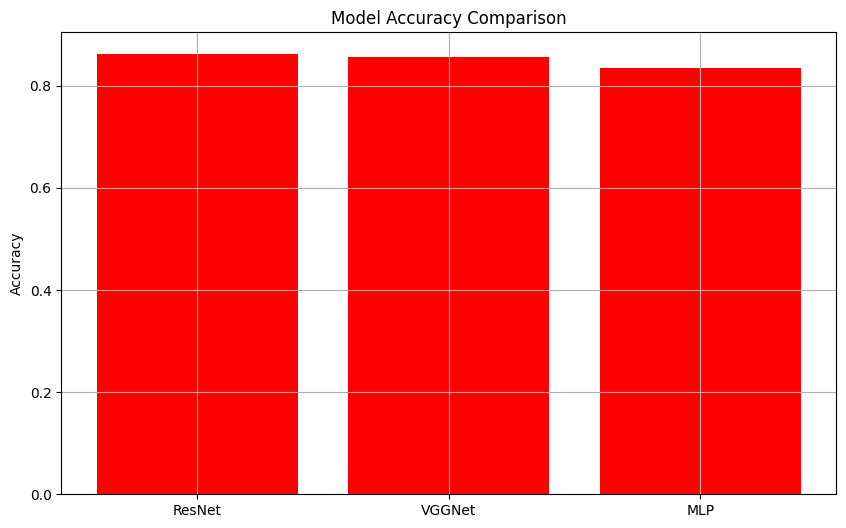

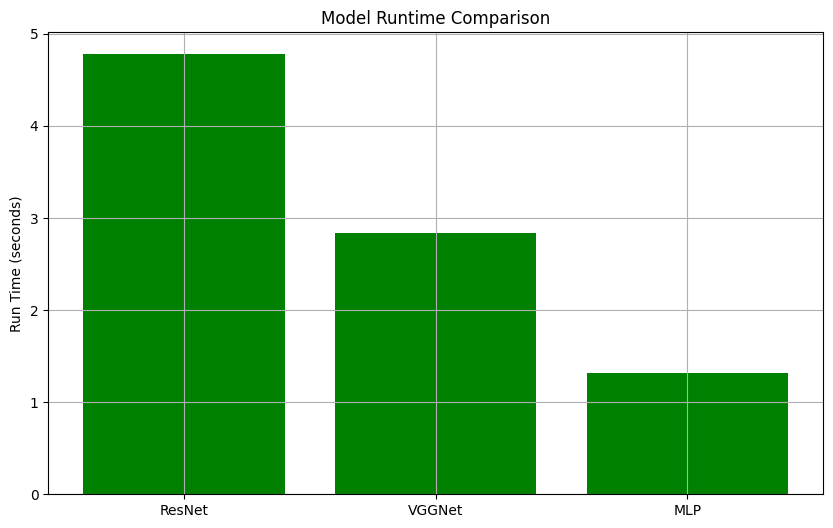

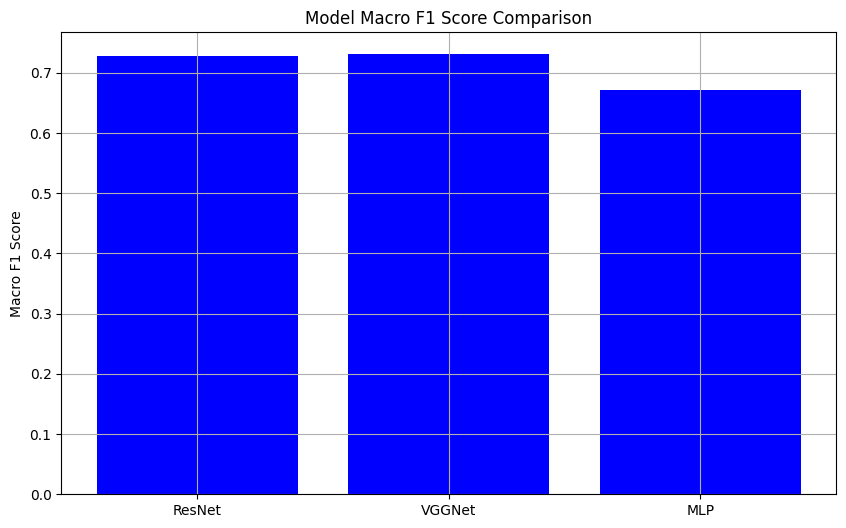

In [93]:
import pandas as pd

# Create a dataframe with performance metrics for all models
data = {
    'Model': ['ResNet', 'VGGNet', 'MLP'],
    'Accuracy': [accuracy_resnet, accuracy_vggnet, accuracy_mlp],
    'Run Time (s)': [runtime_resnet, runtime_vggnet, runtime_mlp],
    'Macro F1 Score': [f1_resnet, f1_vggnet, f1_mlp]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Plot Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color='red')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.show()

# Plot Runtime comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Run Time (s)'], color='green')
plt.ylabel('Run Time (seconds)')
plt.title('Model Runtime Comparison')
plt.grid(True)
plt.show()

# Plot F1 Score comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Macro F1 Score'], color='blue')
plt.ylabel('Macro F1 Score')
plt.title('Model Macro F1 Score Comparison')
plt.grid(True)
plt.show()

2.Overfitting Evaluation Across Models

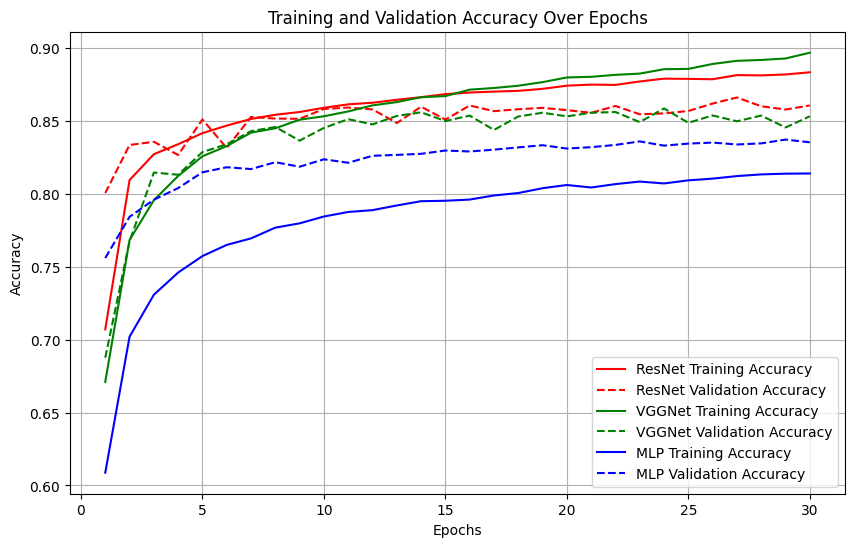

In [94]:
resnet_train_acc = history_resnet_best.history['accuracy']
resnet_val_acc = history_resnet_best.history['val_accuracy']
epochs_resnet = range(1, len(resnet_train_acc) + 1)  # Epochs for ResNet

vggnet_train_acc = history_vggnet_best.history['accuracy']
vggnet_val_acc = history_vggnet_best.history['val_accuracy']
epochs_vggnet = range(1, len(vggnet_train_acc) + 1)  # Epochs for VGGNet

mlp_train_acc = history_mlp_best.history['accuracy']
mlp_val_acc = history_mlp_best.history['val_accuracy']
epochs_mlp = range(1, len(mlp_train_acc) + 1)  # Epochs for MLP

plt.figure(figsize=(10, 6))

plt.plot(epochs_resnet, resnet_train_acc, 'r', label='ResNet Training Accuracy')
plt.plot(epochs_resnet, resnet_val_acc, 'r--', label='ResNet Validation Accuracy')

plt.plot(epochs_vggnet, vggnet_train_acc, 'g', label='VGGNet Training Accuracy')
plt.plot(epochs_vggnet, vggnet_val_acc, 'g--', label='VGGNet Validation Accuracy')

plt.plot(epochs_mlp, mlp_train_acc, 'b', label='MLP Training Accuracy') # Use epochs_mlp for MLP
plt.plot(epochs_mlp, mlp_val_acc, 'b--', label='MLP Validation Accuracy') # Use epochs_mlp for MLP


plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)